In [28]:
from sqlalchemy import create_engine
import pandas as pd 
import numpy as np
mysql_setting = {
    'host' : "10.10.10.4",
    'dbname': "spider",
    'user': "root",
    'password': "qwerasdf"
}

def getDatabaseConn():
    engine = create_engine('mysql://{user}:{password}@{host}:3306/{dbname}'.format(**mysql_setting), echo=False)
    conn = engine.connect()
    return conn
conn = getDatabaseConn()

In [275]:
sql = """
    select publish_time, position_name, position_labels, salary, work_year, education, second_type, city, department
    from lagou_recruit_day
"""

def salarySplit(line):
    import re
    res = re.match(r'([\d]+)K-([\d]+)K', line)
    if not res:
        res = re.match(r'([\d]+)k-([\d]+)k', line)
    if res:
        salary_low = res[1]
        salary_high = res[2]
        salary_mean = (int(salary_low) + int(salary_high)) / 2
    else:
        res = re.match(r'([\d]+).*', line)
        salary_low = res[1]
        salary_high = res[1]
        salary_mean = res[1]
    return pd.Series([int(salary_low), int(salary_high), int(salary_mean)])

res = pd.read_sql(sql, conn)

# 第四季度每天招聘数量

In [276]:
def time2Date(pdate):
    from datetime import datetime
    date_time = datetime.strptime(pdate, '%Y-%m-%d %H:%M:%S')
    date = date_time.strftime('%Y-%m-%d')
    weakend_ords = date_time.strftime('%W')
    day_ords = date_time.strftime('%w')
    hour_ords = date_time.strftime('%H')
    return pd.Series([date, weakend_ords, day_ords, hour_ords])

salary_df = res['salary'].apply(salarySplit).rename(columns={0:'salary_low', 1:'salary_high', 2:'salary_mean'})

date_df = res['publish_time'].apply(time2Date).rename(columns={0:'date', 1:'weakend_ords', 2:'day_ords', 3:'hour_ords'})

res_deal = pd.concat([res, salary_df, date_df] ,axis=1)

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import seaborn as sbn

In [163]:
res_g = res_deal.rename(columns={'hour_ords': '24小时制时间'}).groupby('24小时制时间')

# 每天时段招聘数频率图

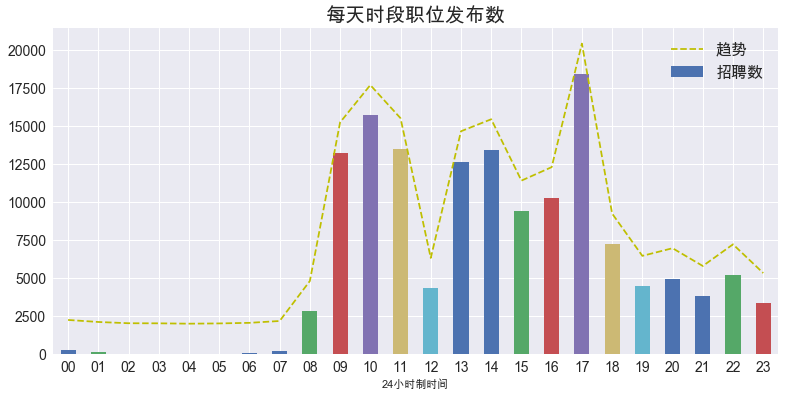

In [164]:
sbn.set()
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False
f, ax = plt.subplots(figsize=(13, 6))
s1 = res_g.size()
s2 = s1.apply(lambda x: x + 2000)
plt.title('每天时段职位发布数',fontsize=20)
s1.plot(kind='bar', grid=True, label='招聘数')
s2.plot(kind='line', grid=True, label='趋势', style='y--', fontsize=14)
plt.legend(fontsize=16)


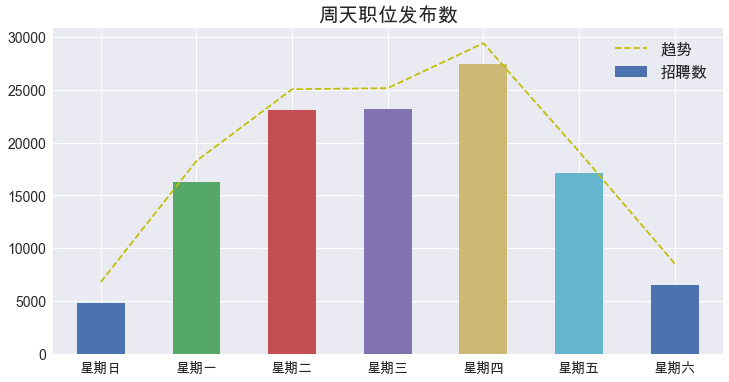

In [602]:
plt.figure(figsize=(12,6))
s3 = pd.Series(res_deal.groupby('day_ords').size().values, index = ['星期日', '星期一', '星期二', '星期三', '星期四', '星期五', '星期六'])
s4 = s3.apply(lambda x: x + 2000)
plt.title('周天职位发布数',fontsize=20)
s3.plot(kind='bar', grid=True, label='招聘数')
s4.plot(kind='line', grid=True, label='趋势', style='y--', fontsize=14)
plt.legend(fontsize=16)

# 各天招聘数量

In [8]:
res_g_date = res_deal.rename(columns={'date': '日期'}).groupby('日期')

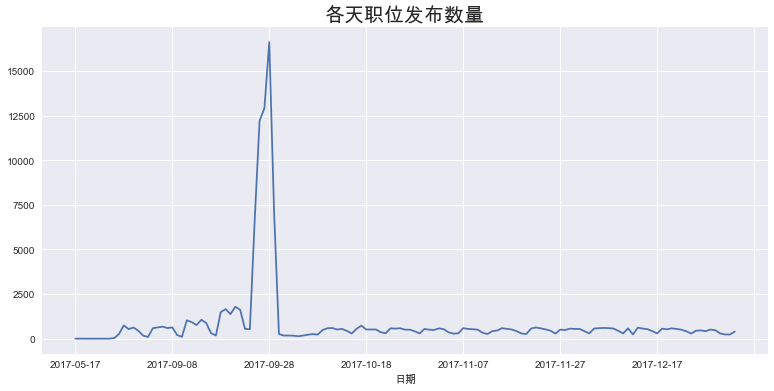

In [9]:
plt.figure(figsize = (13, 6))
plt.title('各天职位发布数量',fontsize=20)
res_g_date.size().plot(kind='line')

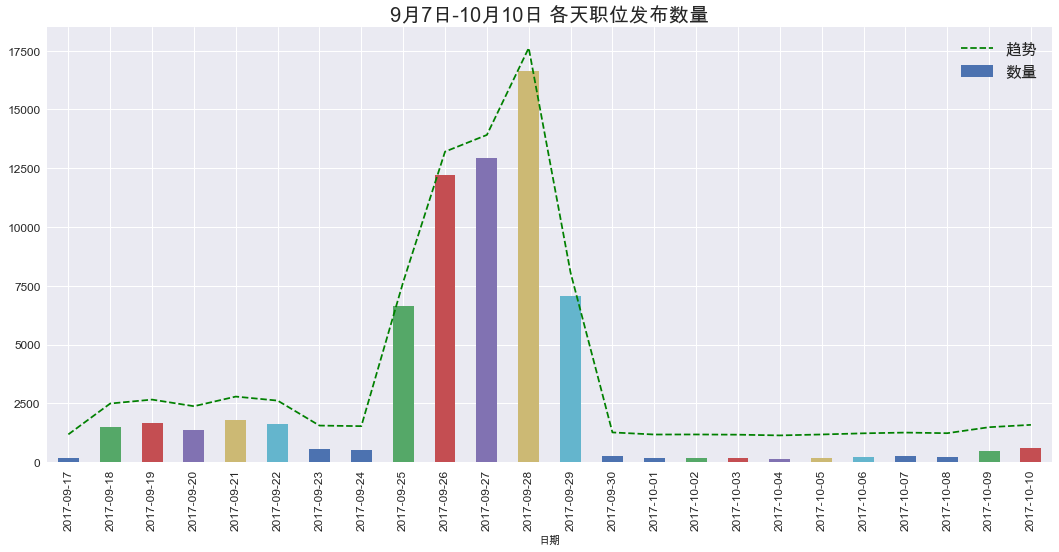

In [577]:
plt.figure(figsize = (18, 8))
plt.title('9月7日-10月10日 各天职位发布数量',fontsize=20)
day_num = res_g_date.size().loc['2017-09-17':'2017-10-10']
day_num.apply(lambda x: x + 1000).plot(kind='line', grid=True, style='g--', label='趋势')
day_num.plot(kind='bar', grid=True, label='数量', fontsize=12)
plt.legend(fontsize=16)
plt.savefig("filename.png")

In [11]:
def getPositionRank(df, column_name):
    res_list = ','.join(df[column_name]).split(',')
    res_def = pd.DataFrame(res_list, index=np.arange(len(res_list)))
    res_def = res_def.rename(columns={0: 'position_labels'})
    res_group = res_def.groupby('position_labels')
    # 销售岗
    sale_total_num = res_group.size()[False ^ res_group.size().index.str.contains('销售|客户代表')].sum()
    # 教师
    teacher_total_num = res_group.size()[False ^ res_group.size().index.str.contains('教师|老师')].sum()
    # 人事
    renshi_total_num = res_group.size()[False ^ res_group.size().index.str.contains('人事')].sum()
    # 前端
    frontend_total_num = res_group.size()[False ^ res_group.size().index.str.contains('前端')].sum()

    res_choose = res_group.size()[True ^ res_group.size().index.str.contains(
        '教师|老师|销售|客户代表|五险一金|节日福利|双休|立即上岗|应届生|员工旅游|交通补助|培训|出差补贴|话补|加班补助|全勤奖|人事|带薪年假|前端开发')]
#     res_choose['销售'] = sale_total_num
    res_choose['教师'] = teacher_total_num
    res_choose['人事'] = renshi_total_num
    res_choose['前端开发'] = frontend_total_num
    return res_choose

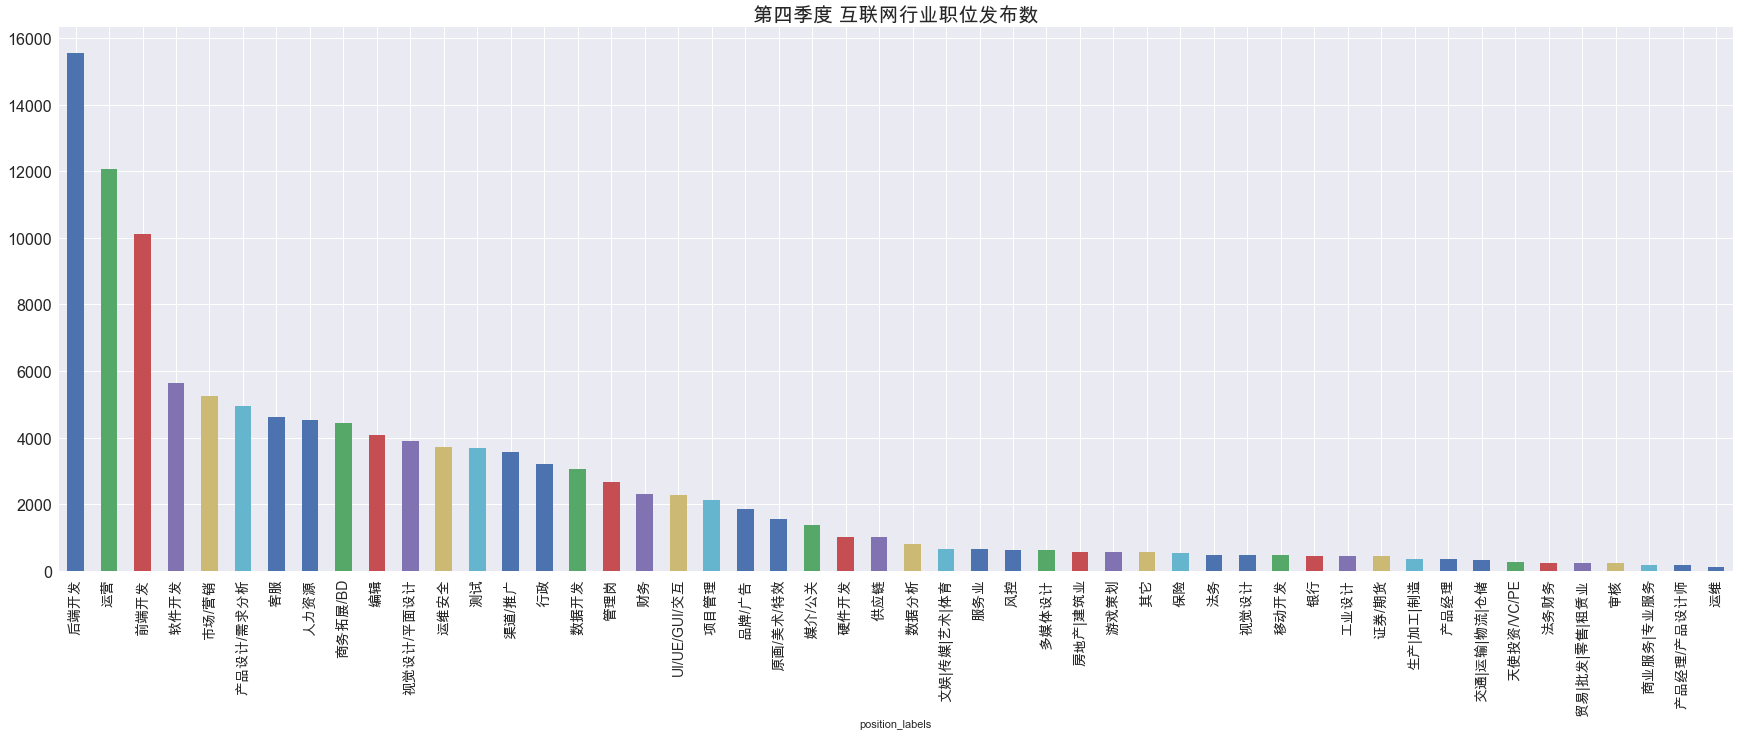

In [12]:
f, ax = plt.subplots(figsize=(30,10))
# 设置坐标标签字体大小
plt.xticks(fontsize=14)
plt.yticks(fontsize=16)
plt.title('第四季度 互联网行业职位发布数',fontsize=20)
getPositionRank(res_deal, 'second_type').sort_values(ascending=False).head(50).plot(kind='bar')
plt.savefig("filename1.png")

# 编程语言岗位数

In [13]:
language_list = ['javascript', 'python', 'java', 'ruby', 'php', 'c\\+\\+', 'css', 'c\\#', 'go', 'typescript', 'shell', 'swift', 'scala', 'ios', 'DBA', 'matlab', 'html5', 'hadoop', 'AI']

In [14]:
language_rank = {}
for language in language_list:
    name = language.replace('\\', '')
    name = 'objective-c' if name == 'ios' else name
    query_name = ['position_name', 'position_labels']
    n = 0
    for item in query_name:
        n += res_deal[res_deal[item].str.contains(language)].size
    language_rank[name] = n
lg_series = pd.Series(language_rank)
code_df = pd.DataFrame([lg_series], index=['数量']).T.sort_values(['数量'], ascending=True)
code_df

,数量
typescript,0
scala,0
shell,48
ruby,80
css,80
javascript,160
matlab,976
swift,1008
c++,3232
AI,3328


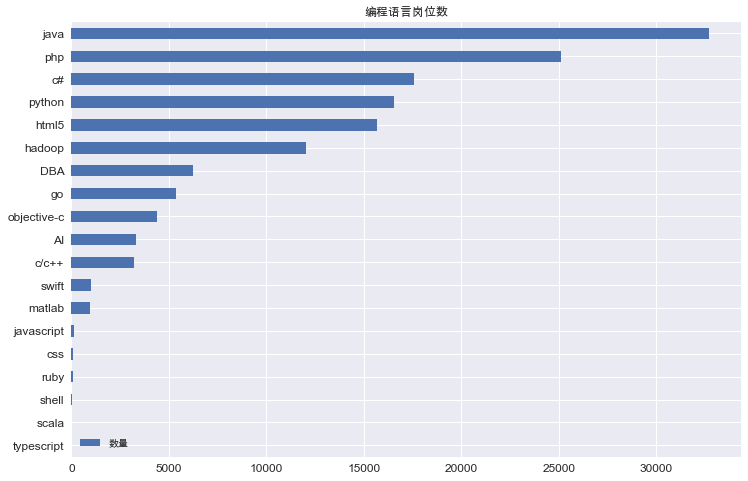

In [15]:
code_df.rename(index={'c++':'c/c++'}).plot(kind='barh', stacked=True, figsize=(12,8), fontsize=12, title='编程语言岗位数')

In [16]:
res_deal.salary_mean = res_deal.salary_mean.apply(lambda x: int(x))

In [17]:
def judgePosition(line):
    for item in language_list:
        if line.find(item) != -1:
            return pd.Series([item])
        elif item == language_list[-1]:
            return pd.Series(['other'])
res_code_deal = res_deal['position_name'].apply(judgePosition)

In [18]:
res_code_df = pd.concat([res_deal, res_code_deal] ,axis=1).rename(columns={0:'code_type'})

In [19]:
code_salary_df = pd.DataFrame(res_code_df[res_code_df.code_type != 'other'], columns=['salary_mean', 'code_type']).groupby('code_type').describe().sort_values(('salary_mean','mean'), ascending=False)
code_salary_df

salary_mean                                                      
                 count       mean        std   min    25%   50%    75%   max
code_type                                                                   
AI                96.0  21.812500  11.485746   1.0  14.75  22.0  30.00  50.0
DBA              215.0  16.888372   8.273740   5.0  11.00  15.0  21.50  60.0
hadoop            23.0  16.304348   6.884995   5.0  12.00  15.0  21.00  32.0
css                1.0  16.000000        NaN  16.0  16.00  16.0  16.00  16.0
go                63.0  15.015873   7.386762   4.0  10.00  15.0  19.00  35.0
ruby               4.0  14.750000  10.307764   8.0   8.75  10.5  16.50  30.0
python           172.0  13.703488   6.250089   2.0   9.00  12.0  17.25  35.0
java            2006.0  13.418245   7.251729   1.0   9.00  12.0  16.00  65.0
javascript        10.0  13.400000  11.539305   5.0   6.50   9.0  10.75  35.0
shell              1.0  12.000000        NaN  12.0  12.00  12.0  12.00  12.0
ios              269.0  11.505576   6.415711   3.0   7.00  10.0  13.00  37.0
html5             63.0  10.682540   4.798607   1.0   7.00  10.0  13.50  29.0
php              375.0  10.120000   5.516528   2.0   6.00   9.0  12.00  32.0
matlab             1.0   7.000000        NaN   7.0   7.00   7.0   7.00   7.0

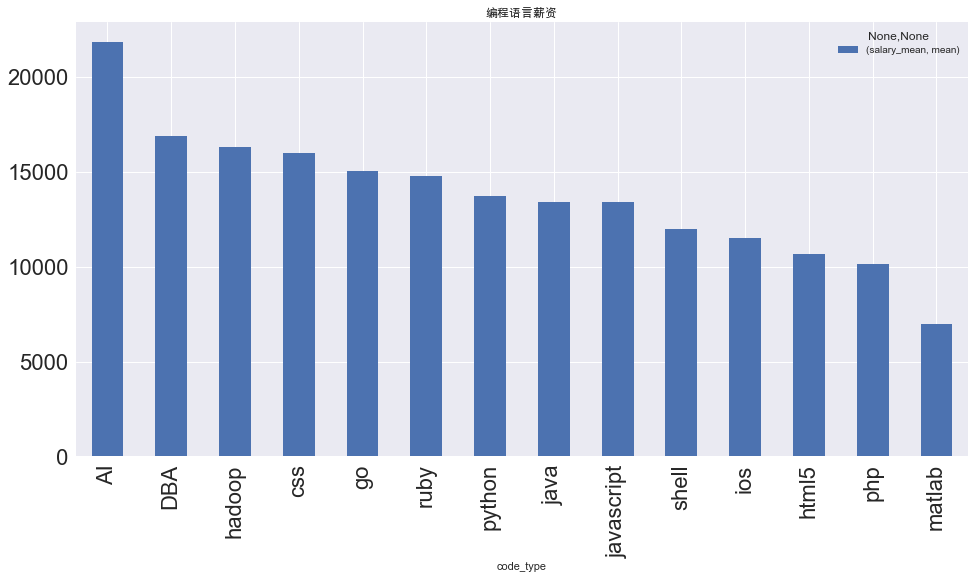

In [20]:
code_salary_df = pd.DataFrame(res_code_df[res_code_df.code_type != 'other'], columns=['salary_mean', 'code_type']).groupby('code_type').describe().sort_values(('salary_mean','mean'), ascending=False)
# plt.title('编程语言薪资',fontsize=20)
pd.DataFrame(code_salary_df.apply(lambda x: round(x * 1000, 0)), columns=[('salary_mean', 'mean')]).plot(kind='bar', stacked=True, figsize=(16,8), fontsize=22, title='编程语言薪资')

In [671]:
salary_ewc = res_code_df[(res_code_df.code_type != 'other') & (res_code_df.work_year != '不限') & (res_code_df.education != '不限')]
desc_salary_ewc = salary_ewc.groupby('city').describe()
salary_ewc = desc_salary_ewc[True ^ desc_salary_ewc[('salary_mean', 'std')].isnull()].sort_values(('salary_mean', 'mean'), ascending=False)
salary_ewc_list = []
for item_city in salary_ewc.index:
    salary_ewc_dict = {}
    salary_ewc_dict['name'] = item_city
    salary_ewc_dict['value'] = round(salary_ewc.loc[item_city][('salary_mean', 'mean')], 2)
    salary_ewc_list.append(salary_ewc_dict)
salary_ewc

salary_mean                                                    
           count       mean       std  min    25%   50%    75%   max
city                                                                
北京         200.0  21.800000  8.091189  2.0  15.00  22.0  26.00  50.0
上海         179.0  19.530726  7.628517  7.0  14.00  19.0  22.50  45.0
杭州         234.0  19.081197  7.781749  5.0  15.00  18.0  22.00  47.0
深圳         188.0  16.920213  7.268643  5.0  12.00  15.0  20.00  65.0
泉州           3.0  15.000000  7.549834  7.0  11.50  16.0  19.00  22.0
广州         157.0  13.082803  7.420486  1.0   9.00  12.0  15.00  65.0
南京         175.0  12.857143  4.948835  3.0  10.00  12.0  15.00  37.0
珠海          28.0  12.785714  5.593363  6.0   7.00  12.5  15.00  25.0
苏州          80.0  11.787500  3.973627  4.0   9.00  12.0  15.00  22.0
成都         185.0  11.210811  5.061995  4.0   7.00  10.0  14.00  27.0
武汉         193.0  10.948187  3.853760  3.0   8.00  11.0  12.00  30.0
天津          81.0  10.765432  3.522327  4.0   9.00  11.0  12.00  27.0
温州           6.0  10.666667  3.386247  8.0   9.00   9.0  11.25  17.0
长沙         112.0  10.508929  3.156562  5.0   8.00  10.0  12.00  20.0
金华           2.0  10.500000  4.949747  7.0   8.75  10.5  12.25  14.0
东莞          24.0  10.500000  3.776357  5.0   7.75  11.0  12.00  22.0
福州          50.0  10.060000  4.062823  5.0   7.00   9.5  11.75  27.0
厦门          80.0  10.037500  3.219575  4.0   7.00  10.0  12.00  18.0
合肥          71.0  10.028169  3.513126  4.0   7.00  10.0  12.00  22.0
宁波          17.0  10.000000  3.335416  5.0   7.00   9.0  12.00  15.0
廊坊           7.0  10.000000  2.828427  7.0   8.00  10.0  11.00  15.0
西安         131.0   9.992366  3.317775  4.0   8.00  10.0  12.00  22.0
重庆          62.0   9.838710  3.020116  4.0   8.00  10.0  12.00  20.0
大连          46.0   9.804348  3.324118  2.0   8.00   9.5  11.75  22.0
无锡          25.0   9.560000  3.305047  5.0   7.00   9.0  12.00  20.0
济南          49.0   9.530612  3.329803  5.0   7.00   9.0  11.00  22.0
青岛          42.0   9.523810  3.528546  6.0   7.00   8.5  11.00  20.0
郑州         124.0   9.169355  3.461100  4.0   7.00   9.0  11.00  30.0
盐城           2.0   9.000000  4.242641  6.0   7.50   9.0  10.50  12.0
中山           8.0   8.875000  2.587746  5.0   6.75   9.5  11.00  12.0
长春           6.0   8.833333  2.316607  6.0   7.25   8.5  10.50  12.0
惠州          11.0   8.727273  3.068906  5.0   6.00   9.0  10.00  15.0
贵阳          12.0   8.583333  2.810963  5.0   6.75   8.5  10.00  15.0
南昌          15.0   8.533333  2.972893  3.0   7.00   8.0  10.00  14.0
绍兴           2.0   8.500000  2.121320  7.0   7.75   8.5   9.25  10.0
南宁          14.0   8.500000  2.564551  4.0   7.00   8.0  10.75  12.0
南通           7.0   8.428571  2.299068  5.0   7.00   9.0   9.50  12.0
嘉兴           3.0   8.333333  2.081666  6.0   7.50   9.0   9.50  10.0
沈阳           9.0   8.111111  3.515837  5.0   7.00   7.0   8.00  17.0
常州          10.0   8.100000  3.446415  4.0   6.00   6.5  10.25  15.0
石家庄         17.0   7.941176  2.357716  4.0   7.00   8.0   9.00  12.0
太原          16.0   7.750000  2.236068  5.0   6.00   7.0   9.00  12.0
烟台           6.0   7.500000  2.073644  5.0   6.00   7.5   9.00  10.0
唐山           3.0   7.000000  1.000000  6.0   6.50   7.0   7.50   8.0
哈尔滨         10.0   6.300000  1.251666  3.0   6.00   7.0   7.00   7.0
徐州           2.0   6.000000  0.000000  6.0   6.00   6.0   6.00   6.0
洛阳           2.0   6.000000  1.414214  5.0   5.50   6.0   6.50   7.0
潍坊           3.0   5.666667  3.511885  2.0   4.00   6.0   7.50   9.0
临沂           2.0   5.500000  2.121320  4.0   4.75   5.5   6.25   7.0
威海           2.0   5.500000  2.121320  4.0   4.75   5.5   6.25   7.0
扬州           2.0   5.000000  0.000000  5.0   5.00   5.0   5.00   5.0

In [184]:
# res_deal.groupby('second_type').describe().sort_values(('salary_mean', 'mean'), ascending=False)
res_deal.head()

,publish_time,position_name,position_labels,salary,work_year,education,second_type,city,department,salary_low,salary_high,salary_mean,date,weakend_ords,day_ords,hour_ords
0,2017-08-30 17:50:37,金融顾问,风控,3K-6K,不限,不限,风控,安庆,淘车无忧金融部招聘,3,6,4,2017-08-30,35,3,17
1,2017-08-30 17:54:00,市场经理,市场拓展,3K-6K,不限,不限,市场/营销,安庆,淘车无忧市场部招聘,3,6,4,2017-08-30,35,3,17
2,2017-08-31 18:00:45,销售,NULL,3K-6K,不限,大专,销售,安庆,淘车无忧销售部招聘,3,6,4,2017-08-31,35,4,18
3,2017-08-31 18:02:54,按揭,二手车贷款,3K-6K,不限,大专,保险,安庆,淘车无忧金融部招聘,3,6,4,2017-08-31,35,4,18
4,2017-08-31 18:14:36,市场专员,车商维护,3K-6K,不限,大专,渠道/推广,安庆,淘车无忧市场部招聘,3,6,4,2017-08-31,35,4,18


In [6]:
sql_position_type = '''
    select * from position_type
'''
pt_df = pd.read_sql(sql_position_type, conn)

# 处理分类第三层的职位薪资

In [7]:
position_name = pt_df[pt_df['parent_id'] > 7].position_name.values
position_third = {}
for item in list(set(position_name)):
    try:
        item = 'c\+\+' if item == 'c++' else item
        values_list = res_deal[res_deal['position_name'].str.contains(item)].salary_mean.values
        if len(values_list) > 0:
            item_mean = np.mean(np.array(values_list))
            position_third[item] = int(item_mean * 1000)
    except Exception as e:
        print(item)

C++


In [8]:
res_deal[res_deal['position_name'].str.contains('c\+\+')].salary_mean.values

array([10, 27, 27, 10, 22, 25, 15,  9, 12,  7, 12,  8, 12, 11, 20, 13, 11,
       12, 11, 10, 10, 20, 25,  4, 18, 13,  6, 12,  7, 11,  1, 20,  7, 15,
       13,  9, 14,  9, 11, 10, 19,  7,  7,  9,  9, 22, 15, 16, 17, 15, 15,
       14, 20, 10, 27, 11, 22, 18, 15, 12, 11, 10,  8,  8, 12, 12, 12, 12,
       22, 20, 22, 20, 17, 15, 12,  9, 11, 12, 10, 15, 10, 17, 19, 12,  8,
        9, 17, 12,  7, 12, 11, 13, 11, 10, 20,  9, 17, 20, 19, 15, 10, 19,
       12, 12,  8,  8, 14, 12, 12, 11,  6, 11, 12, 11, 26, 10, 10,  7,  7,
       15, 18, 22, 13,  2, 10,  9, 10, 15,  6, 12, 10, 11, 12, 10, 12, 19,
        9, 11, 15, 14, 30, 12, 11, 19, 10, 17, 15, 12, 12, 15, 12, 22,  9,
       22, 17, 30, 17, 11, 16,  5,  7, 10,  7, 10, 12, 17, 12, 25,  7,  7,
        9,  6, 11, 12, 12, 15, 12, 11, 30, 15, 15, 20, 10, 10,  5, 12, 12,
        9, 20, 27, 22, 13, 45, 20, 15, 13, 20, 27,  4, 11, 15, 20, 37,  5])

In [9]:
# pd.DataFrame(list(position_third.items()), columns={0:'职位', 1:'平均薪资'})
pt_third_df = pd.DataFrame(list(position_third.items()), columns=['position_name', 'salary_mean'])

# 处理第一，二层的职位薪资

In [10]:
try:
    first_position_dict = {}
    for first_key in pt_df[pt_df['parent_id'] == 0].index:
        first_id = pt_df.iloc[first_key].id
        second_ids = pt_df[pt_df.parent_id == first_id].id.values
        second_position_dict = {}
        for child_id in second_ids:
            pt_third_query_df = pt_third_df[pt_third_df['position_name'].isin(pt_df[pt_df['parent_id'] == child_id].position_name.values)]
            second_position_dict[child_id] = int(np.mean(np.array(pt_third_query_df['salary_mean'])))
        first_position_dict[first_id] = int(np.mean(np.array(list(second_position_dict.values()))))
        first_position_dict = dict(list(first_position_dict.items()) + list(second_position_dict.items()))
except Exception as e:
    print(e)
salary_id_position_df = pd.DataFrame(list(first_position_dict.items()), columns=['id', 'salary_mean'])
df_parent = pd.merge(pt_df[0:45], salary_id_position_df, how='left', on='id')
df_child = pd.merge(pt_df[45:], pt_third_df, how='left', on='position_name')
salary_res_df = pd.concat([df_parent, df_child[~df_child.salary_mean.isnull()]])

In [11]:
salary_res_df

,id,parent_id,position_name,salary_mean
0,1,0.0,技术,14433.0
1,2,0.0,产品,12630.0
2,3,0.0,设计,14811.0
3,4,0.0,运营,10321.0
4,5,0.0,市场与销售,11754.0
5,6,0.0,职能,11515.0
6,7,0.0,金融,17056.0
7,8,1.0,后端开发,14217.0
8,9,1.0,移动开发,12761.0
9,10,1.0,前端开发,13032.0


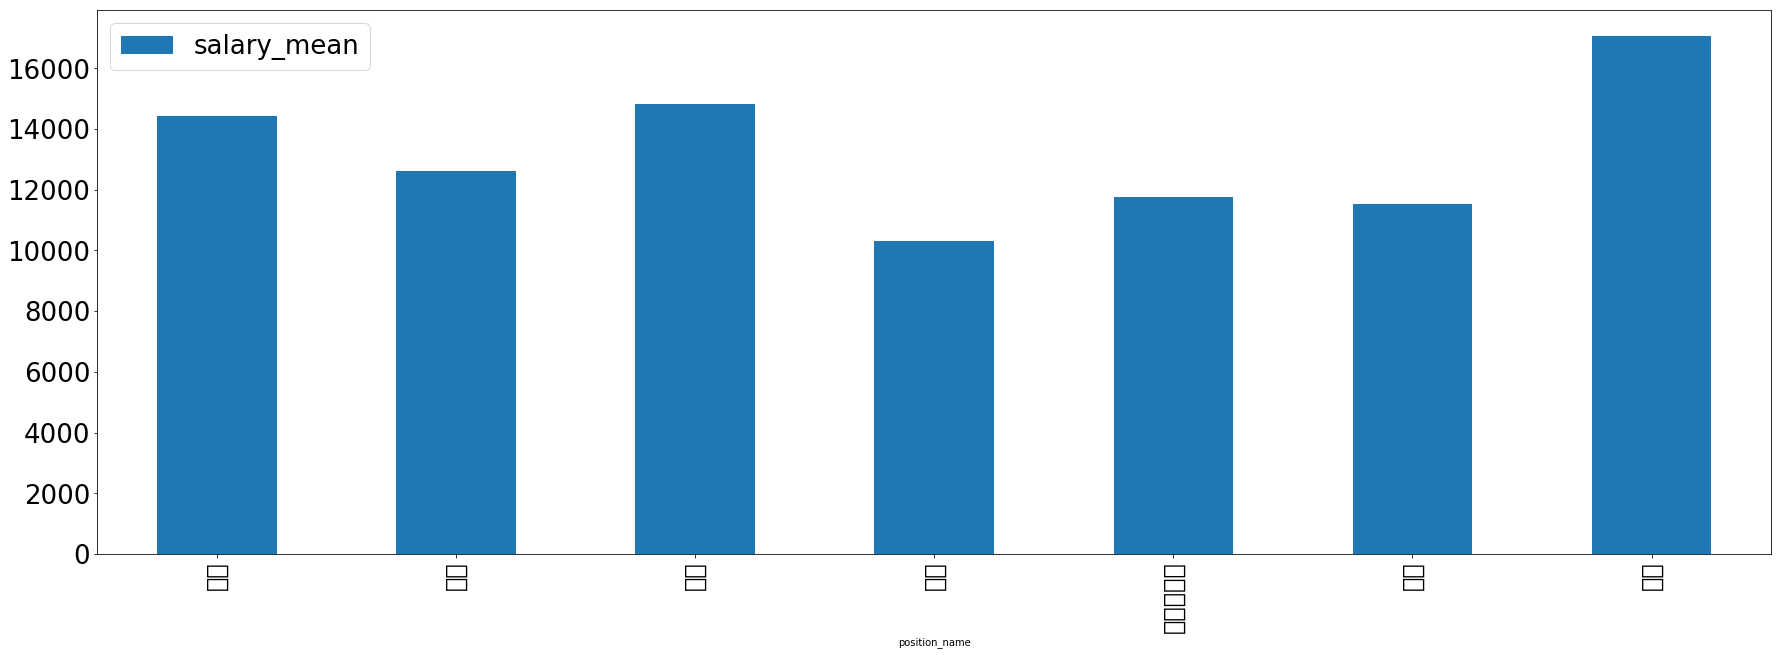

In [17]:
f, ax = plt.subplots(figsize=(30,10))
plt.xticks(fontsize=24)
plt.yticks(fontsize=26)
pd.DataFrame(salary_res_df[salary_res_df['parent_id'] == 0].set_index('position_name'), columns=['salary_mean']).plot(kind='bar', ax=ax)
plt.legend(fontsize=26)

In [689]:
from sqlalchemy import text
sql_zhilian = '''
    select position_name, city, salary_low, salary_high, DATE_FORMAT(publish_time,"%Y-%m-%d") publish_time, work_year, education, position_type from zhilian_position where publish_time <>  'NULL' and publish_time <>  '最新'
'''

zl_df = pd.read_sql(text(sql_zhilian), conn)

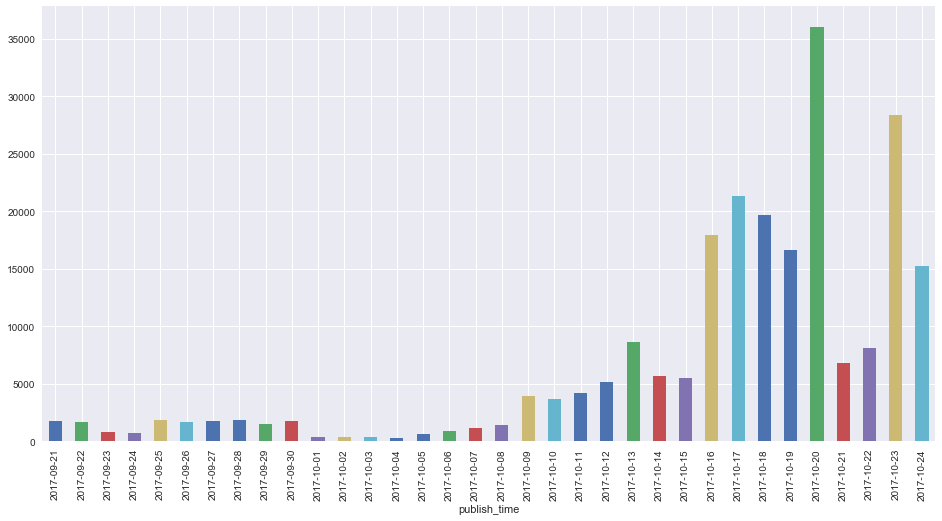

In [703]:
zl_df[(zl_df['publish_time'] > '2017-09-20') & (zl_df['publish_time'] < '2017-10-25')].groupby('publish_time').size().plot(kind='bar', figsize=(16,8))

In [16]:
lg_unity3d = res_deal[(res_deal.city == '成都') & (res_deal.position_name.str.contains('unity') | (res_deal.position_name.str.contains('u3d')))]

In [24]:
lg_unity3d.salary_low = lg_unity3d.salary_low.apply(lambda x: int(x))
lg_unity3d.salary_high = lg_unity3d.salary_high.apply(lambda x: int(x))
lg_unity3d.salary_mean = lg_unity3d.salary_mean.apply(lambda x: int(x))

/Users/monstar/Envs/py3env/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [28]:
lg_unity3d.pivot_table(index='work_year', columns=['education']).fillna('--')

salary_high             salary_low           salary_mean           
education          不限    大专    本科         不限    大专  本科          不限     大专  本科
work_year                                                                    
1-3年                9  13.5    --        5.5  7.75  --           7  10.25  --
1年以下               --    10    --         --     5  --          --      7  --
3-5年          20.3333    21  24.5         14    15  16          17     18  20
不限                 --    --    12         --    --   8          --     --  10

In [13]:
df_1 = salary_res_df[:7]
df_2 = salary_res_df[7:45]
df_3 = salary_res_df[45:]

In [14]:
PTNum_dict = {}
for item in df_3['position_name'].values:
    num = res_deal[(res_deal.position_name.str.contains(item))].size
    PTNum_dict[item] = num

In [15]:
def getPT3Num(line):
    return pd.Series(PTNum_dict[line])
df_3_deal = pd.concat([df_3, df_3.position_name.apply(getPT3Num)], axis=1)

In [16]:
def getPT2Num(line):
    num = sum(df_3_deal[df_3_deal['parent_id'] == line][0].values)
    return pd.Series(num)
df_2_deal = pd.concat([df_2, df_2.id.apply(getPT2Num)], axis=1)

In [17]:
def getPT1Num(line):
    num = sum(df_2_deal[df_2_deal['parent_id'] == line][0].values)
    return pd.Series(num)
df_1_deal = pd.concat([df_1, df_1.id.apply(getPT1Num)], axis=1)

In [18]:
salary_num_res_df = pd.concat([df_1_deal, df_2_deal, df_3_deal]).rename(columns={0: 'recruit_num'})

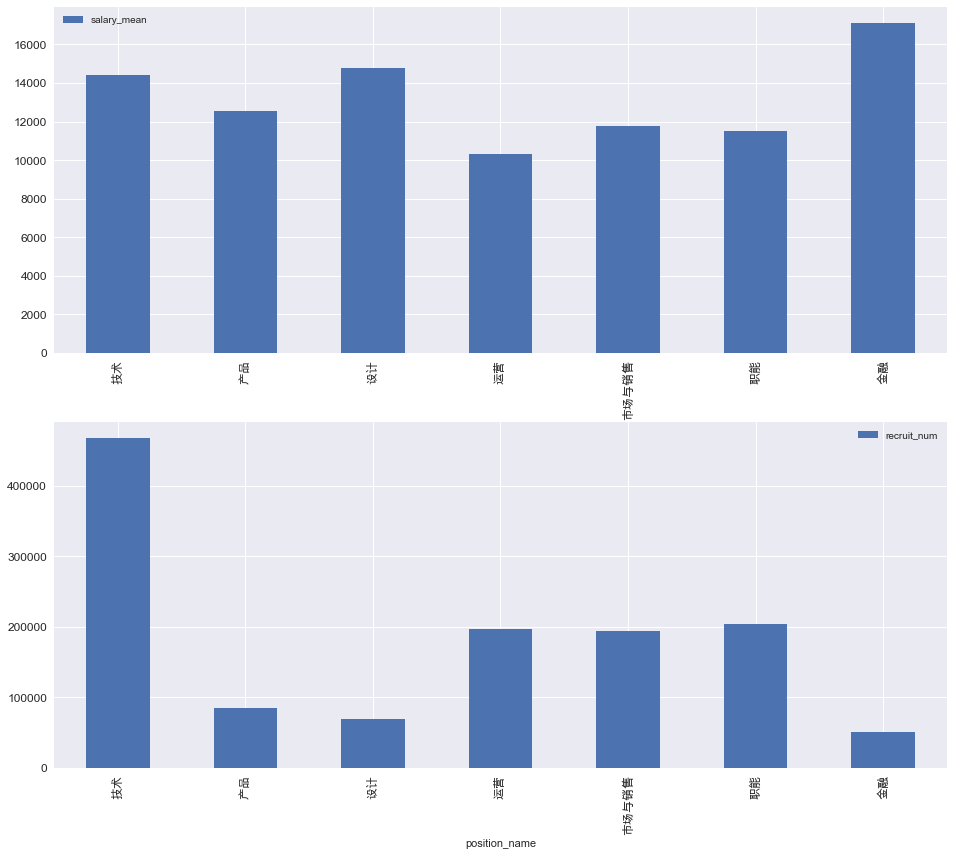

In [343]:
f, ax = plt.subplots(2, 1, figsize=(16, 14))
sn1 = salary_num_res_df[['position_name', 'salary_mean']][:7].set_index('position_name').plot(kind='bar', ax=ax[0], fontsize=12)
sn2 = salary_num_res_df[['position_name', 'recruit_num']][:7].set_index('position_name').plot(kind='bar', ax=ax[1], fontsize=12)

In [20]:
salary_num_res_df

,id,parent_id,position_name,salary_mean,recruit_num
0,1,0.0,技术,14433.0,478416
1,2,0.0,产品,12630.0,87392
2,3,0.0,设计,14811.0,70992
3,4,0.0,运营,10321.0,201760
4,5,0.0,市场与销售,11754.0,199904
5,6,0.0,职能,11515.0,211184
6,7,0.0,金融,17056.0,51856
7,8,1.0,后端开发,14217.0,202864
8,9,1.0,移动开发,12761.0,42128
9,10,1.0,前端开发,13032.0,25584


In [21]:
def positionSN(parent_id):
    dict_salary = {}
    dict_num = {}
    df_1 = salary_num_res_df[['position_name', 'salary_mean', 'recruit_num']][salary_num_res_df.parent_id == parent_id].set_index('position_name')
    df_1 = df_1.sort_values('salary_mean')
    for item in df_1.index:
        dict_salary[item] = df_1.loc[item].salary_mean
        dict_num[item] = df_1.loc[item].recruit_num
    return dict_salary, dict_num

list_salary =[]
list_num = []
for i in range(1, 46):
    dict_salary, dict_num = positionSN(i)
    list_salary.append(dict_salary)
    list_num.append(dict_num)

# 总览图

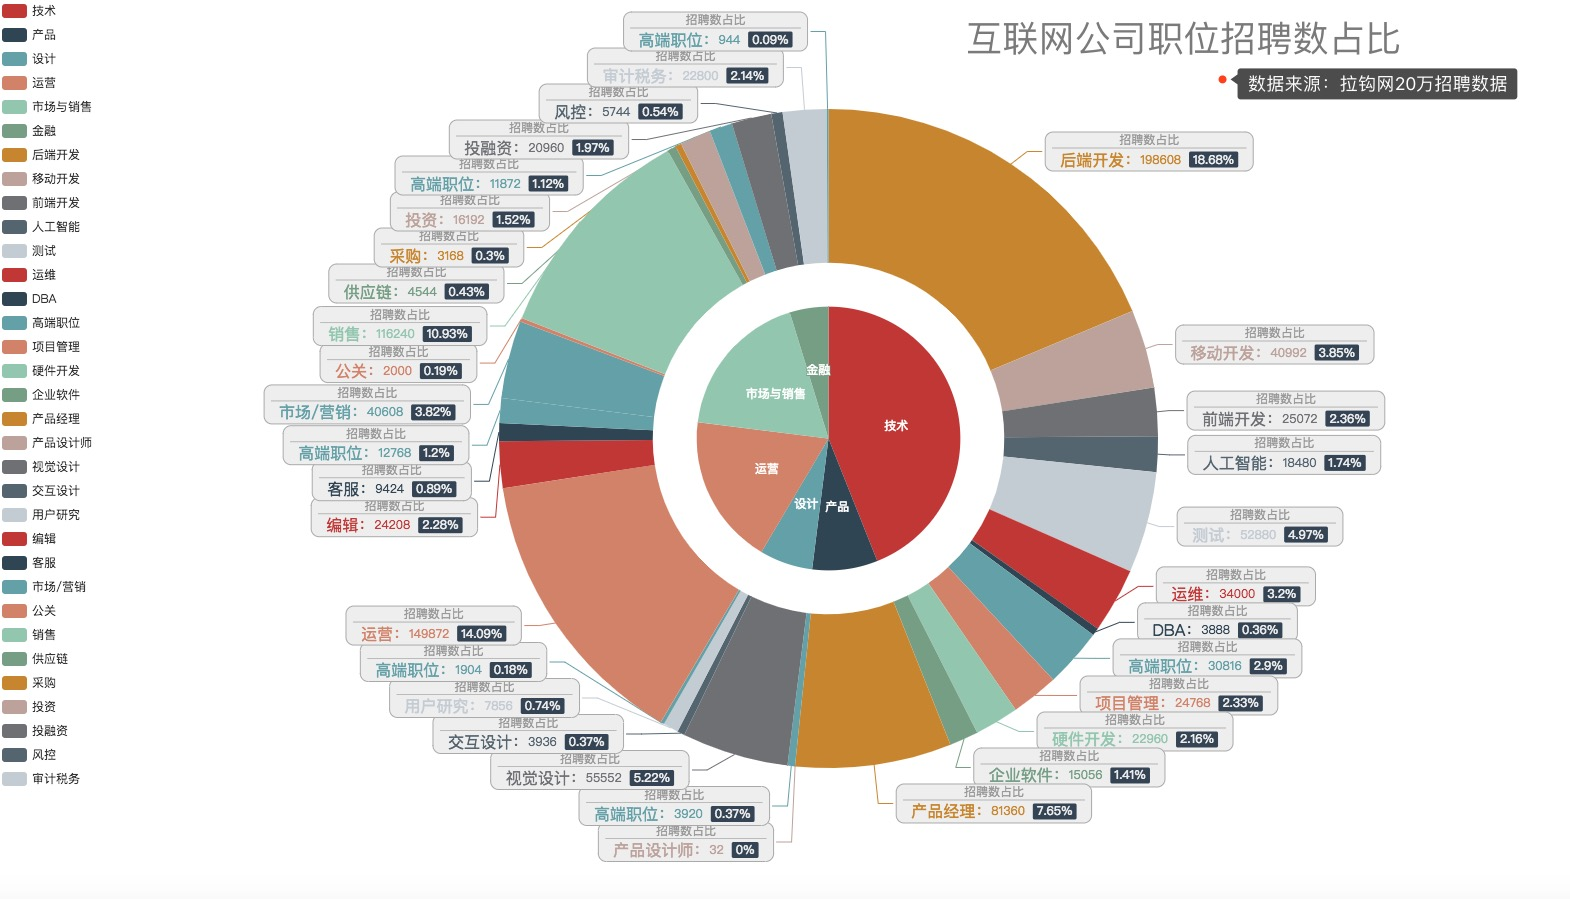

In [664]:
total_pt_index = 7
position_names_list = salary_num_res_df[salary_num_res_df.parent_id.isin(salary_num_res_df[salary_num_res_df.parent_id == total_pt_index].id.values)].position_name.values
print(list(position_names_list))
print('\r\n')
list1 = []
list2 = []
for name, v in zip(list_num[total_pt_index-1].keys(), list_num[total_pt_index-1].values()):
    list1.append({'value': v, 'name': name})
    for name, v in zip(list_num[salary_num_res_df[(salary_num_res_df.position_name==name) & (salary_num_res_df.parent_id == total_pt_index)].id.values[0] -1].keys(), list_num[salary_num_res_df[(salary_num_res_df.position_name==name) & (salary_num_res_df.parent_id == total_pt_index)].id.values[0]-1].values()):
        list2.append({'value': v, 'name': name})
print(list1)
print('\r\n')
print(list2)

['投资经理', '分析师', '投资助理', '融资', '并购', '行业研究', '投资者关系', '资产管理', '理财顾问', '交易员', '风控', '审计', '法务', '会计', '清算', '投资总监', '融资总监', '风控总监']


[{'value': 22800.0, 'name': '审计税务'}, {'value': 20960.0, 'name': '投融资'}, {'value': 5744.0, 'name': '风控'}, {'value': 944.0, 'name': '高端职位'}]


[{'value': 16144.0, 'name': '会计'}, {'value': 288.0, 'name': '清算'}, {'value': 5616.0, 'name': '法务'}, {'value': 752.0, 'name': '审计'}, {'value': 16.0, 'name': '并购'}, {'value': 832.0, 'name': '资产管理'}, {'value': 192.0, 'name': '投资助理'}, {'value': 1152.0, 'name': '理财顾问'}, {'value': 1168.0, 'name': '交易员'}, {'value': 80.0, 'name': '投资者关系'}, {'value': 13920.0, 'name': '分析师'}, {'value': 256.0, 'name': '行业研究'}, {'value': 1840.0, 'name': '融资'}, {'value': 1504.0, 'name': '投资经理'}, {'value': 5744.0, 'name': '风控'}, {'value': 272.0, 'name': '投资总监'}, {'value': 256.0, 'name': '融资总监'}, {'value': 416.0, 'name': '风控总监'}]


# 职位薪资和招聘数

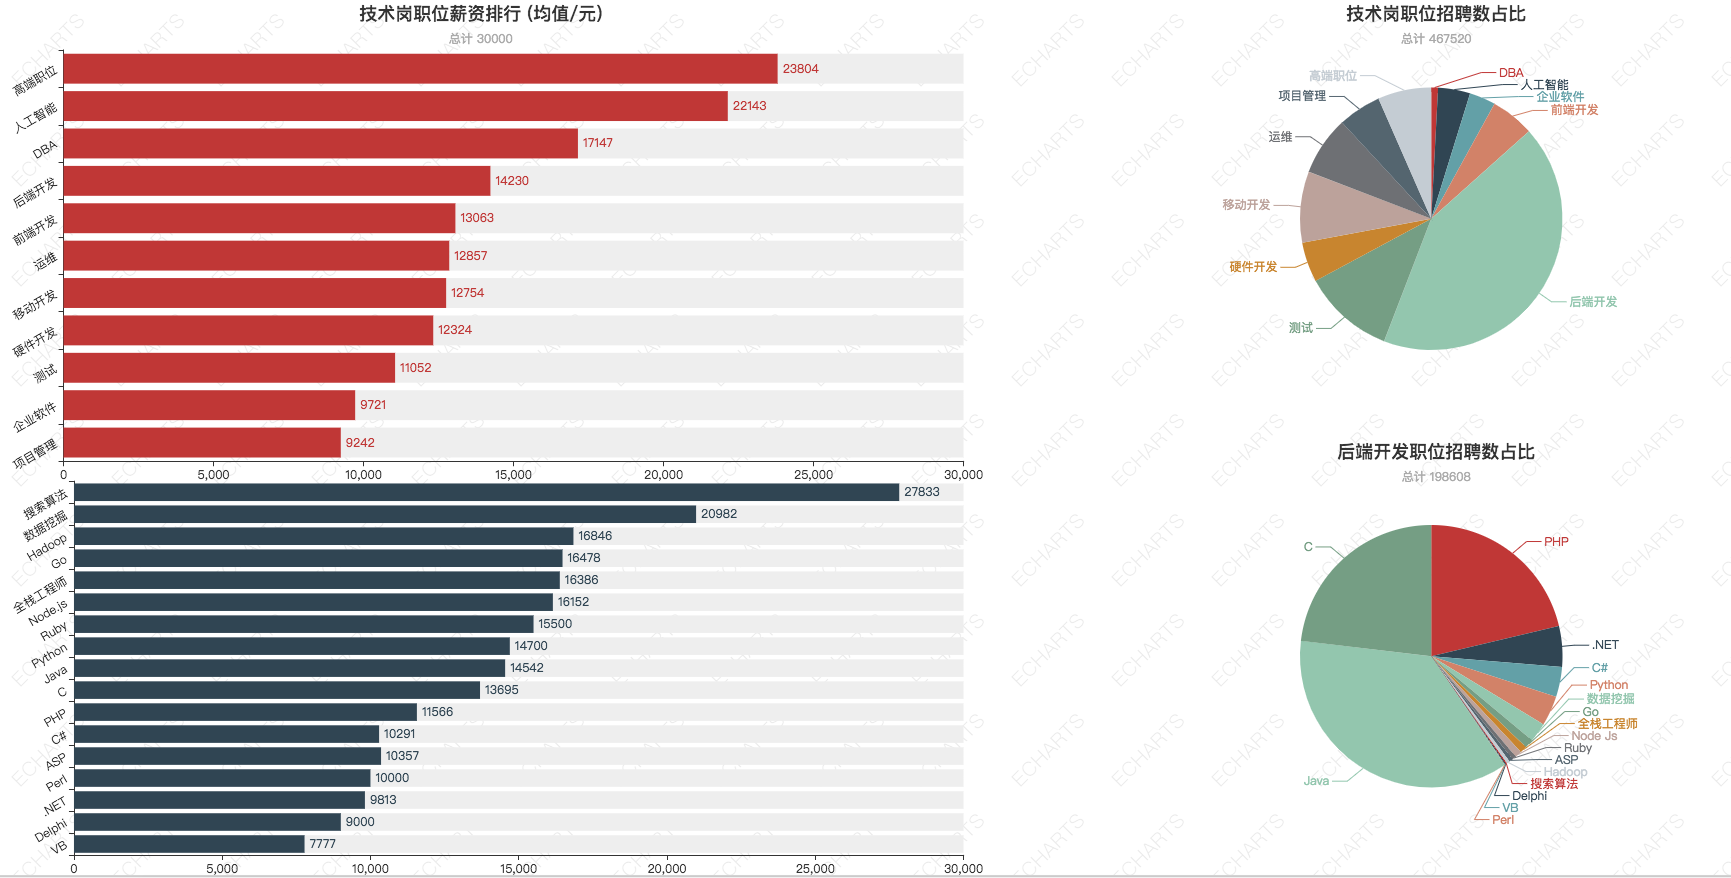

In [694]:
pt_index_pex = 44
pt_index = 45
print(list_salary[pt_index_pex - 1 ])
print(", components:" )
print(list_salary[pt_index-1])
print('\r\n')
print(list_num[pt_index_pex - 1])
print(list_num[pt_index-1])

{'会计': 5731.0, '清算': 9444.0, '法务': 10555.0, '审计': 14127.0}
, components:
{'投资总监': 23705.0, '融资总监': 27375.0, '风控总监': 38500.0}


{'会计': 16144.0, '清算': 288.0, '法务': 5616.0, '审计': 752.0}
{'投资总监': 272.0, '融资总监': 256.0, '风控总监': 416.0}


# 具体职位情况

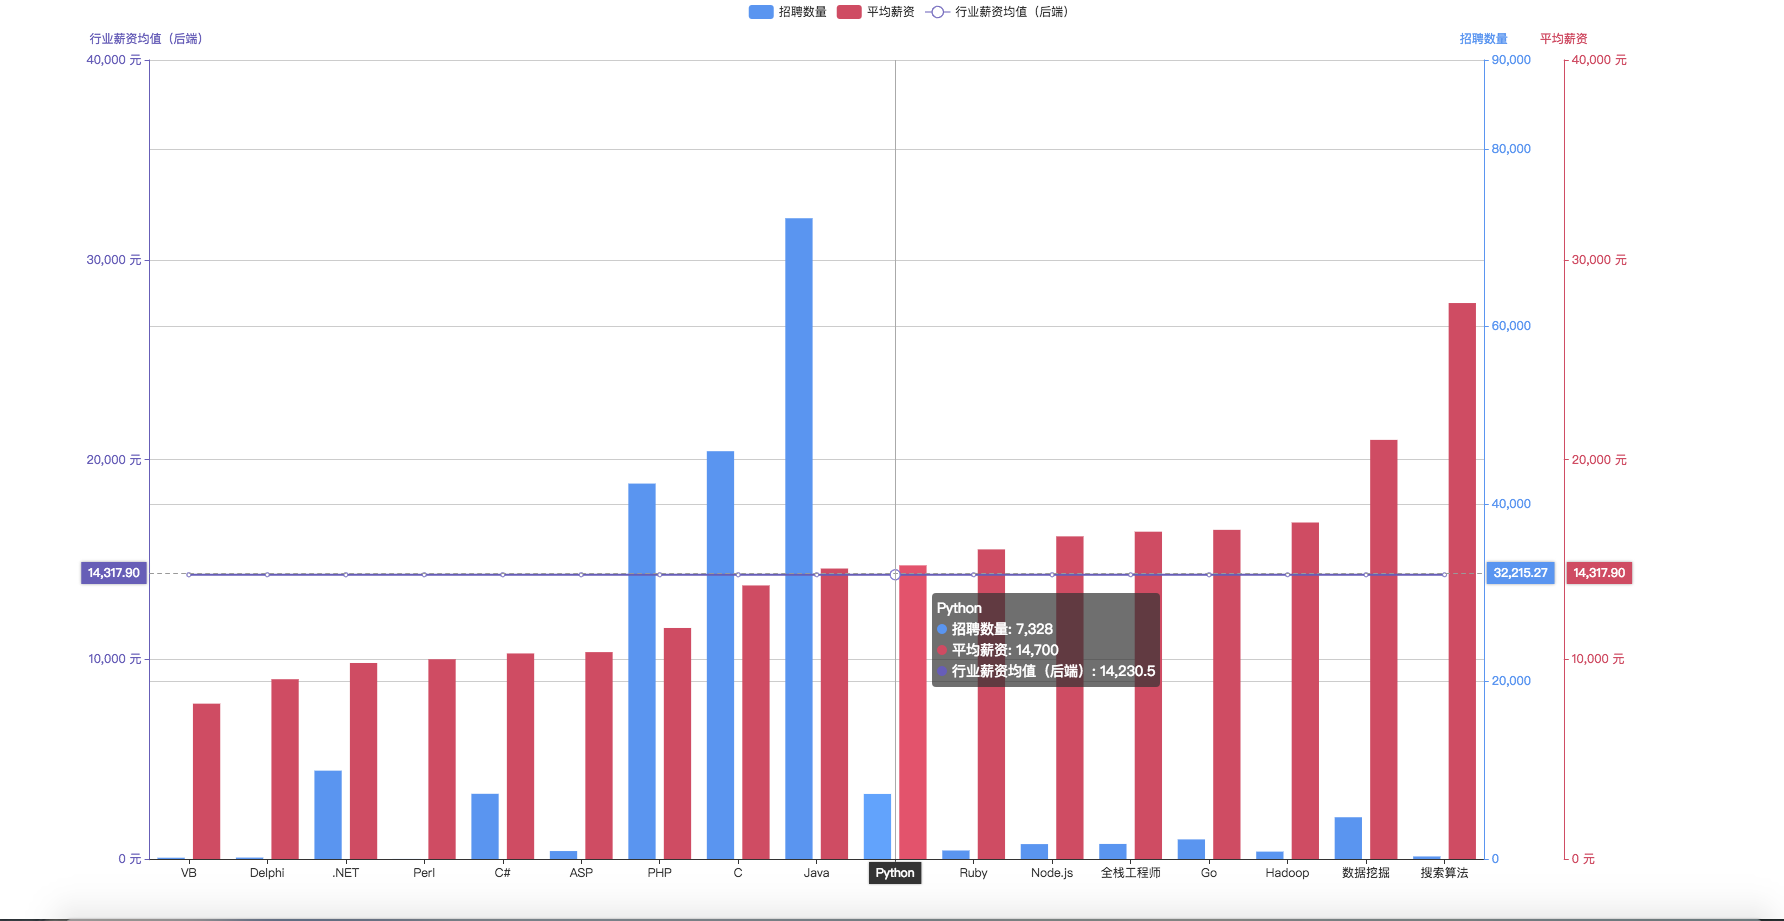

In [746]:
import numpy as np
index_mult = 45
# 职位名称
print(list(list_salary[index_mult-1].keys()))
print('\r\n')
print([
        {
            'name':'招聘数量',
            'type':'bar',
            'data':list(list_num[index_mult-1].values())
        },
        {
            'name':'平均薪资',
            'type':'bar',
            'yAxisIndex': 1,
            'data':list(list_salary[index_mult-1].values())
        },
        {
            'name':'行业薪资均值（' + salary_num_res_df[salary_num_res_df.id == (index_mult)].position_name.values[0] + '）',
            'type':'line',
            'yAxisIndex': 2,
            'data':[round(np.mean(list(list_salary[index_mult-1].values())), 0) for i in range(len(list_salary[index_mult-1].values()))]

        }
    ])

['投资总监', '融资总监', '风控总监']


[{'name': '招聘数量', 'type': 'bar', 'data': [272.0, 256.0, 416.0]}, {'name': '平均薪资', 'type': 'bar', 'yAxisIndex': 1, 'data': [23705.0, 27375.0, 38500.0]}, {'name': '行业薪资均值（高端职位）', 'type': 'line', 'yAxisIndex': 2, 'data': [29860.0, 29860.0, 29860.0]}]


# 三级职位城市分布情况和各城市平均薪资

In [18]:
pt_third = pt_df[pt_df['id'] > 45]

In [19]:
pt_third  

,id,parent_id,position_name
45,46,8.0,Java
46,47,8.0,C++
47,48,8.0,PHP
48,49,8.0,数据挖掘
49,50,8.0,搜索算法
50,51,8.0,精准推荐
51,52,8.0,C
52,53,8.0,C#
53,54,8.0,全栈工程师
54,55,8.0,.NET


In [68]:
res_deal.salary_low = res_deal.salary_low.apply(lambda x: str(x))
res_deal.salary_mean = res_deal.salary_mean.apply(lambda x: int(x))
res_deal.salary_high = res_deal.salary_high.apply(lambda x: str(x))

In [21]:
group_type = ['city', 'work_year', 'education']
for pt_id in pt_third.index:
    query_pt = pt_third.loc[pt_id]['position_name']
    city_sm = res_deal[res_deal.position_name.astype(str).str.contains(query_pt.replace('+', '\+'))].groupby(group_type[0]).describe().fillna(0)
    if len(city_sm) > 0:
        # 按照薪水来排列
        csm_df = city_sm[city_sm[('salary_mean', 'std')] > 0].sort_values(('salary_mean', 'mean'), ascending=False)[[('salary_mean', 'mean')]].apply(lambda x: round(1000 * x, 0))
        csm_list = []
        for item in csm_df.index:
            csm_list.append({'name': item, 'value': csm_df.loc[item].values[0]})
        csm_list
        with open('/Users/monstar/Desktop/a.txt', 'a') as f:
            f.write('\r\n' + query_pt + '\r\n' + str(csm_list[::-1]) + '\r\n' + '\r\n')

In [26]:
res_deal[(res_deal.position_name.astype(str).str.contains('技术合伙人')) & (res_deal.city == '青岛')].groupby(group_type[0]).describe().fillna(0)

salary_high                                                      \
           count       mean        std   min   25%   50%   75%   max   
city                                                                   
青岛           3.0  36.666667  15.275252  20.0  30.0  40.0  45.0  50.0   

     salary_low             ...              salary_mean             \
          count       mean  ...    75%   max       count       mean   
city                        ...                                       
青岛          3.0  26.333333  ...   34.5  49.0         3.0  31.333333   

                                               
            std   min   25%   50%   75%   max  
city                                           
青岛    17.039171  15.0  22.5  30.0  39.5  49.0  

[1 rows x 24 columns]

# 某职位最多金公司

In [142]:
res_deal[(res_deal.city == '成都') & (res_deal.position_name.str.contains('数据挖掘'))].groupby('department').describe().sort_values(('salary_mean', 'mean'), ascending=False)

salary_mean                                                
                       count  mean       std   min    25%   50%    75%   max
department                                                                  
美团点评美团外卖招聘               1.0  30.0       NaN  30.0  30.00  30.0  30.00  30.0
博雅成信大数据招聘                1.0  25.0       NaN  25.0  25.00  25.0  25.00  25.0
tap4funAI招聘              2.0  22.5  3.535534  20.0  21.25  22.5  23.75  25.0
咪咕成都研发中心招聘               1.0  22.0       NaN  22.0  22.00  22.0  22.00  22.0
马上金融招聘                   1.0  22.0       NaN  22.0  22.00  22.0  22.00  22.0
马上金融数据平台部招聘              1.0  22.0       NaN  22.0  22.00  22.0  22.00  22.0
聚美优品金融事业部招聘              1.0  17.0       NaN  17.0  17.00  17.0  17.00  17.0
新希望六和信息中心招聘              1.0  16.0       NaN  16.0  16.00  16.0  16.00  16.0
中创云讯研发部招聘                1.0  15.0       NaN  15.0  15.00  15.0  15.00  15.0
柠檬科技风控研发部招聘              1.0  15.0       NaN  15.0  15.00  15.0  15.00  15.0
文创清科技术中心招聘               1.0  15.0       NaN  15.0  15.00  15.0  15.00  15.0
思特奇Si-tech招聘             3.0  13.0  1.732051  12.0  12.00  12.0  13.50  15.0
启发分期技术部招聘                1.0  12.0       NaN  12.0  12.00  12.0  12.00  12.0
数联易康科技数据中心-工程部招聘         1.0  12.0       NaN  12.0  12.00  12.0  12.00  12.0
米兰网研发部招聘                 1.0  12.0       NaN  12.0  12.00  12.0  12.00  12.0
知数科技星脉招聘                 1.0   7.0       NaN   7.0   7.00   7.0   7.00   7.0
合时代成都研发中心招聘              1.0   7.0       NaN   7.0   7.00   7.0   7.00   7.0
久远银海招聘                   1.0   7.0       NaN   7.0   7.00   7.0   7.00   7.0

## 分析不同级别的城市 各职位薪资情况（年限和教育）

In [34]:
city_detail_sql = "SELECT * FROM spider.city;"
city_detail_df = pd.read_sql(city_detail_sql, conn)

In [39]:
city_classA_list = list(city_detail_df[city_detail_df['type'] == 1].city_name.values)
city_classB_list = list(city_detail_df[city_detail_df['type'] == 2].city_name.values)
city_classC_list = list(city_detail_df[city_detail_df['type'] == 3].city_name.values)
city_classD_list = list(city_detail_df[city_detail_df['type'] == 4].city_name.values)
city_classNewA_list = list(city_detail_df[city_detail_df['type'] == 9].city_name.values)

In [277]:
city_class_salary = []
city_class_salary.append(res_deal[res_deal.city.isin(city_classA_list)][['salary_mean']].describe().loc['50%'].values[0])
city_class_salary.append(res_deal[res_deal.city.isin(city_classNewA_list)][['salary_mean']].describe().loc['50%'].values[0])
city_class_salary.append(res_deal[res_deal.city.isin(city_classB_list)][['salary_mean']].describe().loc['50%'].values[0])
city_class_salary.append(res_deal[res_deal.city.isin(city_classC_list)][['salary_mean']].describe().loc['50%'].values[0])
city_class_salary.append(res_deal[res_deal.city.isin(city_classD_list)][['salary_mean']].describe().loc['50%'].values[0])
city_class_num = []
city_class_num.append(res_deal[res_deal.city.isin(city_classA_list)][['salary_mean']].describe().loc['count'].values[0])
city_class_num.append(res_deal[res_deal.city.isin(city_classNewA_list)][['salary_mean']].describe().loc['count'].values[0])
city_class_num.append(res_deal[res_deal.city.isin(city_classB_list)][['salary_mean']].describe().loc['count'].values[0])
city_class_num.append(res_deal[res_deal.city.isin(city_classC_list)][['salary_mean']].describe().loc['count'].values[0])
city_class_num.append(res_deal[res_deal.city.isin(city_classD_list)][['salary_mean']].describe().loc['count'].values[0])

In [278]:
city_class_label = ['一线城市', '新一线城市', '二线城市', '三线城市', '四线以下城市']

# 不同级别的城市 学历薪资随年限的变化

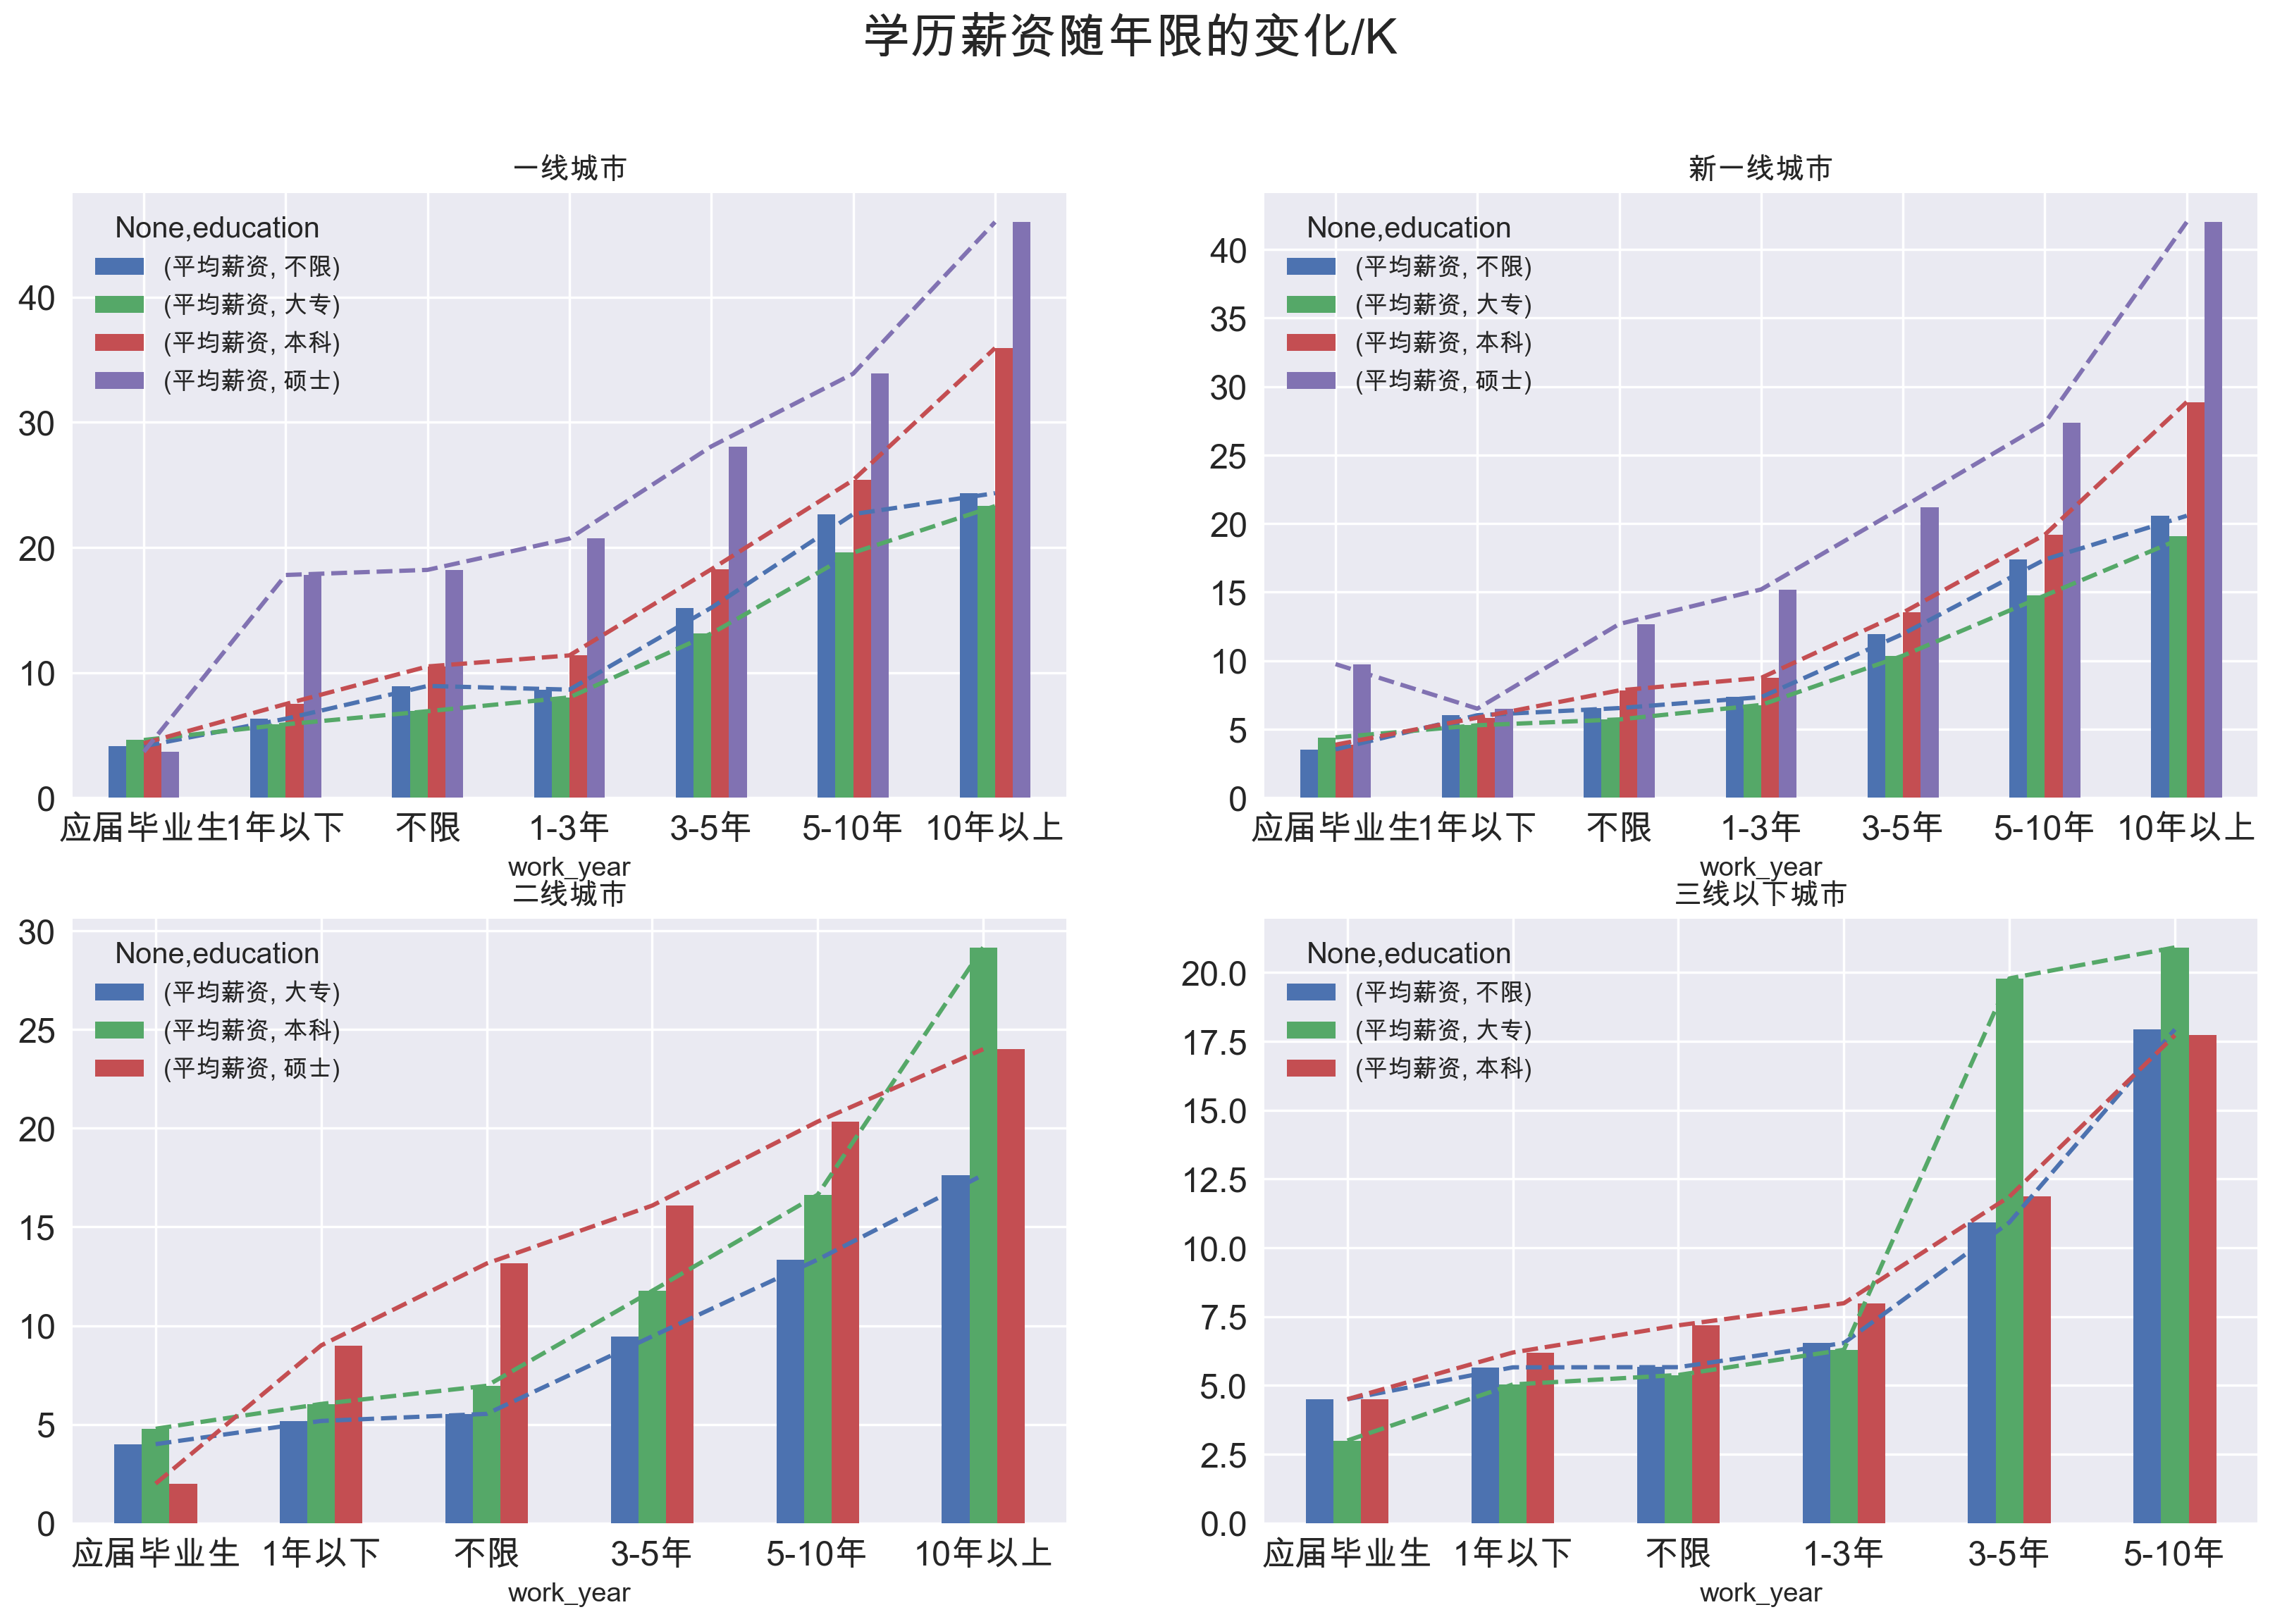

In [279]:
fig, axes = plt.subplots(2, 2, figsize=(7, 18), dpi=250) 
fig.suptitle('学历薪资随年限的变化/K', fontsize=20)
ax0, ax1, ax2, ax3 = axes.ravel()
res_deal[res_deal.city.isin(city_classA_list)].pivot_table(index='work_year', columns='education')[['salary_mean']].fillna('--')[1:].sort_values(('salary_mean', '本科'),ascending=True).rename(columns={'salary_mean':'平均薪资'}).plot(figsize=(16, 10), fontsize=14, title='一线城市', kind='bar', ax=ax0)
res_deal[res_deal.city.isin(city_classA_list)].pivot_table(index='work_year', columns='education')[['salary_mean']].fillna('--')[1:].sort_values(('salary_mean', '本科'),ascending=True).rename(columns={'salary_mean':'平均薪资'}).plot(figsize=(16, 10), fontsize=14, title='一线城市', style='--', ax=ax0, legend=False)

res_deal[res_deal.city.isin(city_classNewA_list)].pivot_table(index='work_year', columns='education')[['salary_mean']].fillna('--').sort_values(('salary_mean', '本科'),ascending=True).rename(columns={'salary_mean':'平均薪资'}).plot(figsize=(16, 10), fontsize=14, title='新一线城市', kind='bar', ax=ax1)
res_deal[res_deal.city.isin(city_classNewA_list)].pivot_table(index='work_year', columns='education')[['salary_mean']].fillna('--').sort_values(('salary_mean', '本科'),ascending=True).rename(columns={'salary_mean':'平均薪资'}).plot(figsize=(16, 10), fontsize=14, title='新一线城市', style='--', ax=ax1, legend=False)

res_deal[res_deal.city.isin(city_classB_list)].pivot_table(index='work_year', columns='education')[['salary_mean']].fillna('--')[1:].sort_values(('salary_mean', '本科'),ascending=True).rename(columns={'salary_mean':'平均薪资'}).plot(figsize=(16, 10), fontsize=14, title='二线城市', kind='bar', ax=ax2)
res_deal[res_deal.city.isin(city_classB_list)].pivot_table(index='work_year', columns='education')[['salary_mean']].fillna('--')[1:].sort_values(('salary_mean', '本科'),ascending=True).rename(columns={'salary_mean':'平均薪资'}).plot(figsize=(16, 10), fontsize=14, title='二线城市', style='--', ax=ax2, legend=False)

res_deal[((res_deal.city.isin(city_classC_list)) | (res_deal.city.isin(city_classD_list))) & (res_deal.work_year != '10年以上')].pivot_table(index='work_year', columns='education')[['salary_mean']].fillna('--').sort_values(('salary_mean', '大专'),ascending=True).rename(columns={'salary_mean':'平均薪资'}).plot(figsize=(16, 10), fontsize=14, title='三线以下城市', kind='bar', ax=ax3)
res_deal[((res_deal.city.isin(city_classC_list)) | (res_deal.city.isin(city_classD_list))) & (res_deal.work_year != '10年以上')].pivot_table(index='work_year', columns='education')[['salary_mean']].fillna('--').sort_values(('salary_mean', '大专'),ascending=True).rename(columns={'salary_mean':'平均薪资'}).plot(figsize=(16, 10), fontsize=14, title='三线以下城市', style='--', ax=ax3, legend=False)
plt.savefig('/Users/monstar/Desktop/a.png')

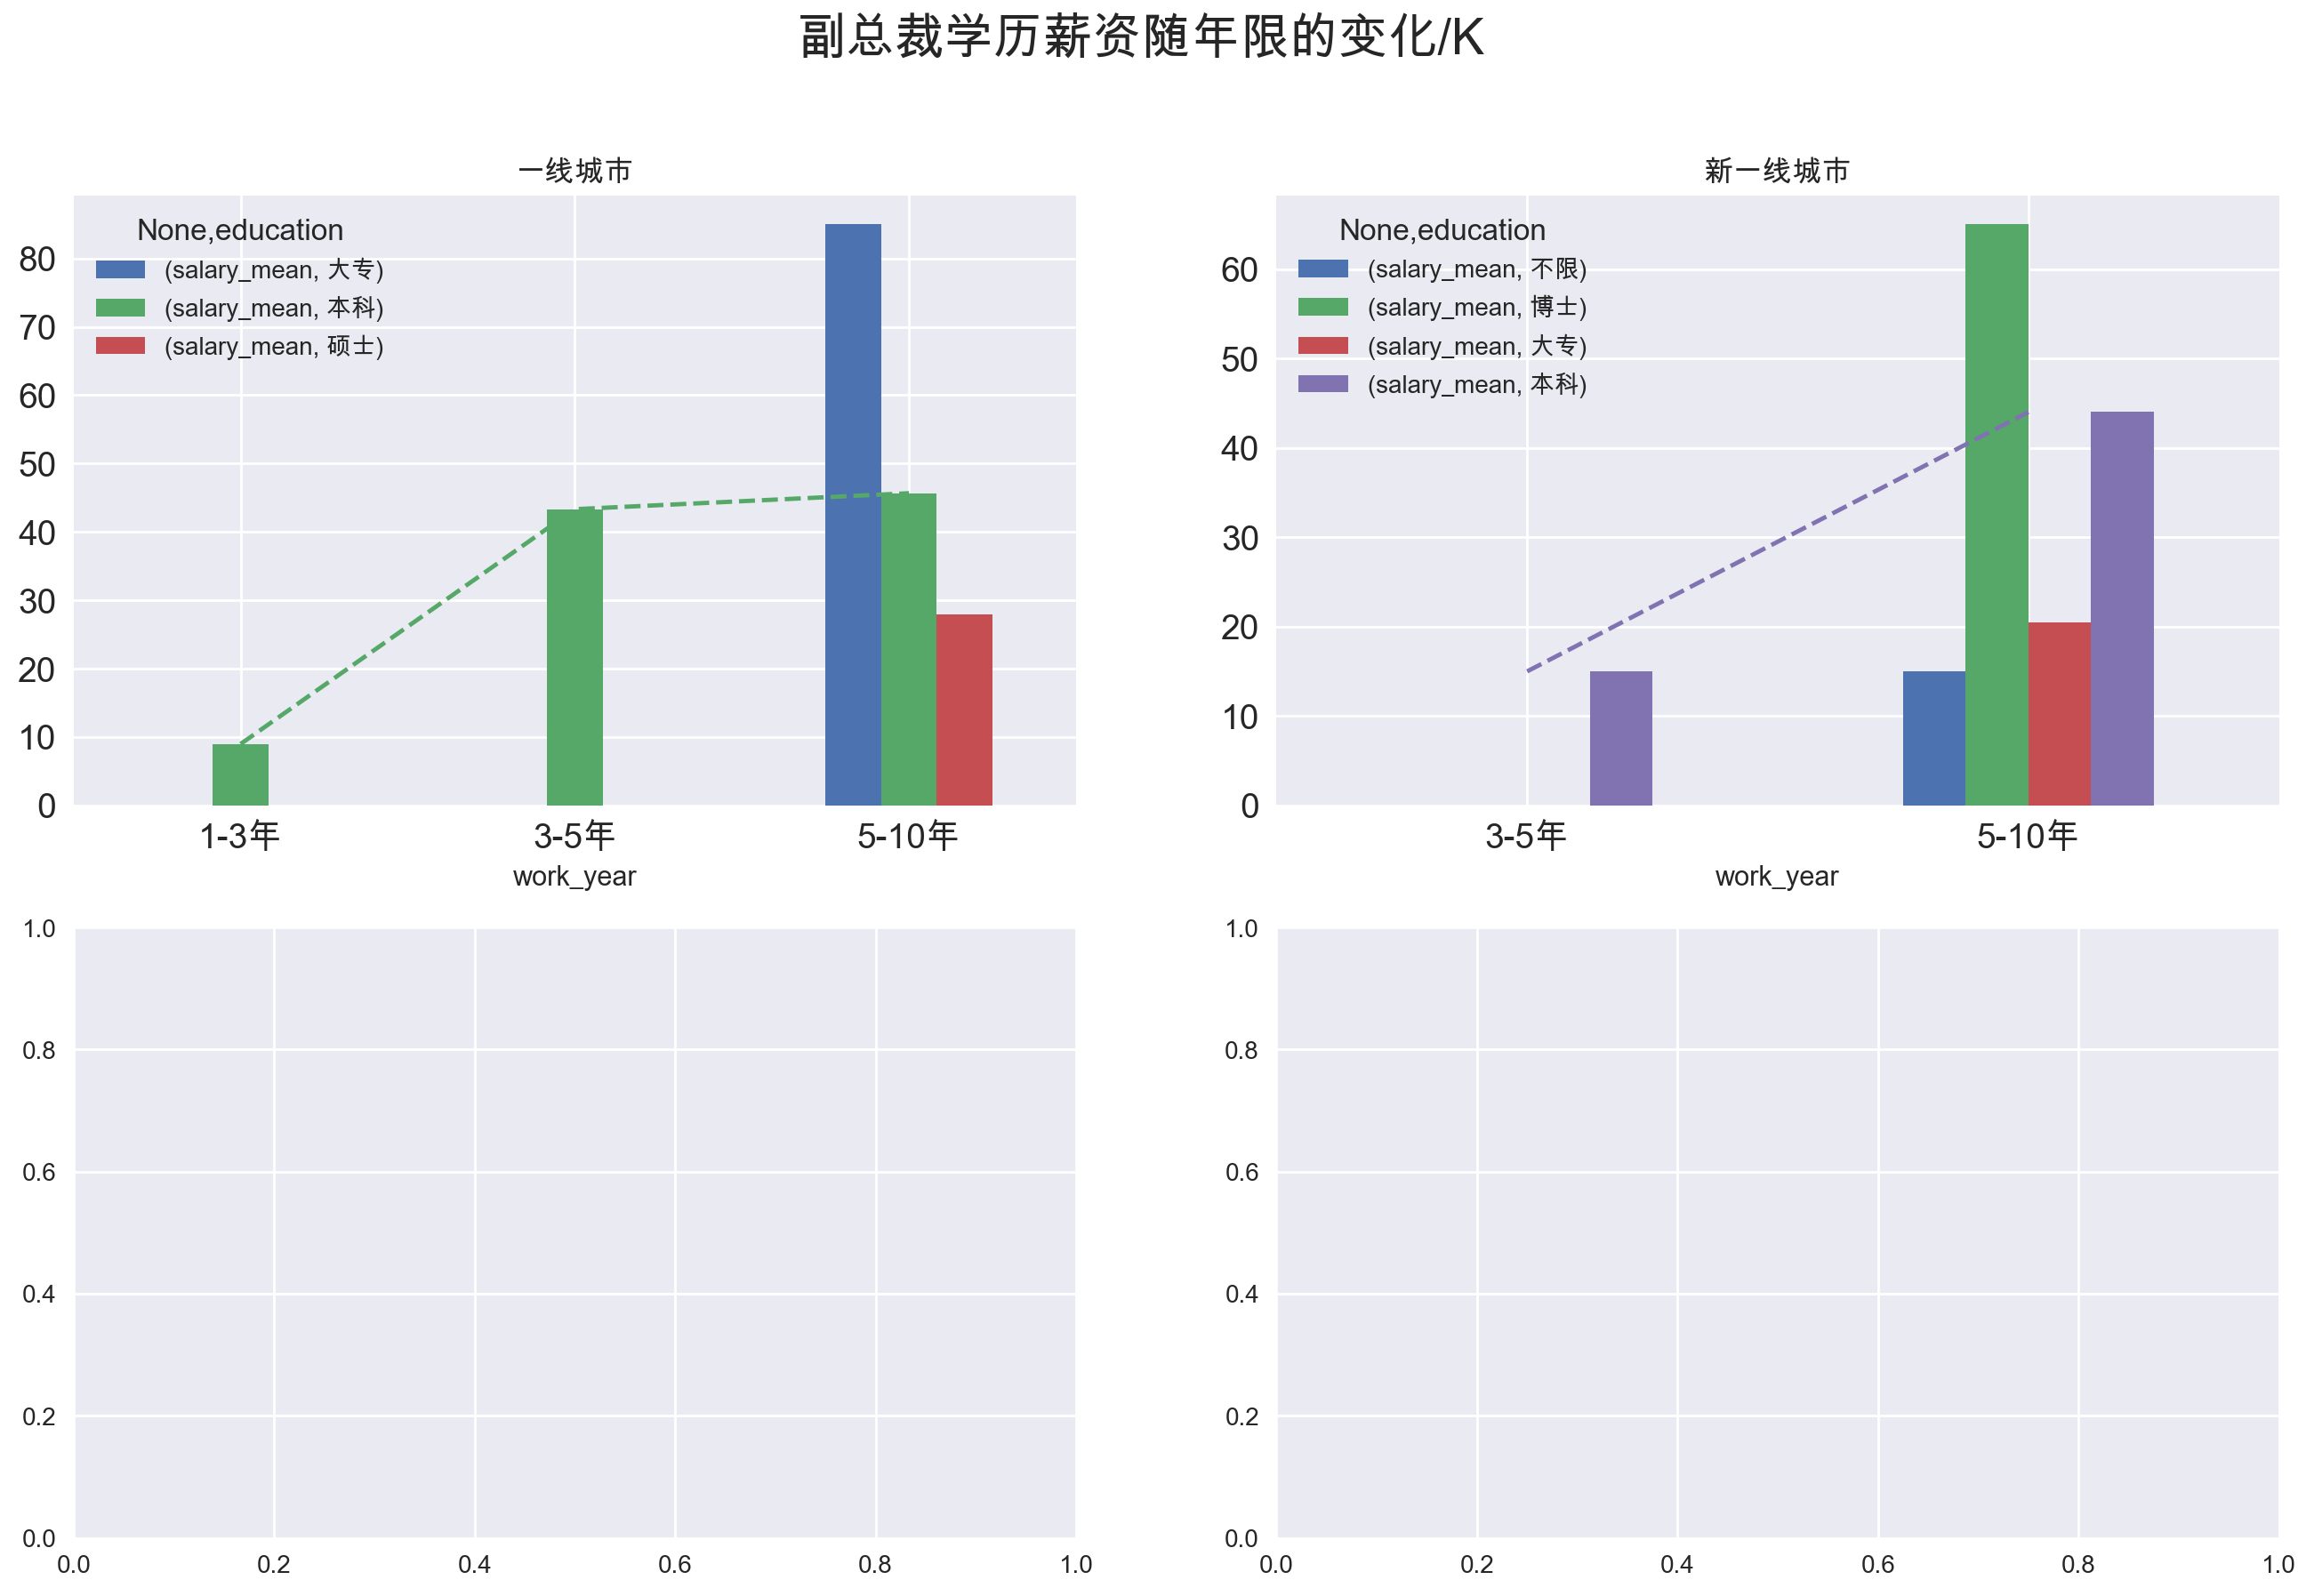

In [905]:

# 参数
pid = 314
salary_type = 'salary_mean'
education_A = '本科'
education_NA = '本科'
education_B = '本科'
education_C = '本科'
current_name = pt_df[pt_df.id == pid].position_name.values[0]
# 一级职位
# position_name = ('|').join(list(pt_df[pt_df.id.isin(pt_df[pt_df.parent_id == pid].id.values)].position_name.values))
# 二级
# position_name = ('|').join(list(pt_df[pt_df.parent_id == pid].position_name.values))
# 三级
position_name = re.escape(current_name)
# 技术岗需要转义
if pid == 8:
    position_name = 'Java|C\+\+|PHP|数据挖掘|搜索算法|精准推荐|C|C\#|全栈工程师|\.NET|Hadoop|Python|Delphi|VB|Perl|Ruby|Node\.js|Go|ASP|Shell'

fig, axes = plt.subplots(2, 2, figsize=(16, 10), dpi=200) 
fig.suptitle(current_name + '学历薪资随年限的变化/K', fontsize=20)
ax0, ax1, ax2, ax3 = axes.ravel()
res_deal[(res_deal.position_name.str.contains(position_name)) & (res_deal.city.isin(city_classA_list)) & (res_deal.work_year != '10年以上')][['work_year', 'education', 'second_type', salary_type]].pivot_table(index='work_year', columns='education').sort_values((salary_type, education_A)).plot(kind='bar', title='一线城市', fontsize=14, ax=ax0)
res_deal[(res_deal.position_name.str.contains(position_name)) & (res_deal.city.isin(city_classA_list)) & (res_deal.work_year != '10年以上')][['work_year', 'education', 'second_type', salary_type]].pivot_table(index='work_year', columns='education').sort_values((salary_type, education_A)).plot(style='--',ax=ax0, legend=False)

res_deal[(res_deal.position_name.str.contains(position_name)) & (res_deal.city.isin(city_classNewA_list)) & (res_deal.work_year != '10年以上')][['work_year', 'education', 'second_type', salary_type]].pivot_table(index='work_year', columns='education').sort_values((salary_type, education_NA)).plot(kind='bar', title='新一线城市', fontsize=14, ax=ax1)
res_deal[(res_deal.position_name.str.contains(position_name)) & (res_deal.city.isin(city_classNewA_list)) & (res_deal.work_year != '10年以上')][['work_year', 'education', 'second_type', salary_type]].pivot_table(index='work_year', columns='education').sort_values((salary_type, education_NA)).plot(style='--', ax=ax1, legend=False)

# res_deal[(res_deal.position_name.str.contains(position_name)) & (res_deal.city.isin(city_classB_list)) & (res_deal.work_year != '10年以上')][['work_year', 'education', 'second_type', salary_type]].pivot_table(index='work_year', columns='education').sort_values((salary_type, education_B)).plot(kind='bar', title='二线城市', fontsize=14, ax=ax2)
# res_deal[(res_deal.position_name.str.contains(position_name)) & (res_deal.city.isin(city_classB_list)) & (res_deal.work_year != '10年以上')][['work_year', 'education', 'second_type', salary_type]].pivot_table(index='work_year', columns='education').sort_values((salary_type, education_B)).plot(style='--', ax=ax2, legend=False)

# res_deal[(res_deal.position_name.str.contains(position_name)) & (res_deal.city.isin(city_classC_list)) & (res_deal.work_year != '10年以上') & (res_deal[salary_type] < 50)][['work_year', 'education', 'second_type', salary_type]].pivot_table(index='work_year', columns='education').sort_values((salary_type, education_C)).plot(kind='bar', title='三线以下城市', fontsize=14, ax=ax3)
# res_deal[(res_deal.position_name.str.contains(position_name)) & (res_deal.city.isin(city_classC_list)) & (res_deal.work_year != '10年以上') & (res_deal[salary_type] < 50)][['work_year', 'education', 'second_type', salary_type]].pivot_table(index='work_year', columns='education').sort_values((salary_type, education_C)).plot(style='--', ax=ax3, legend=False)
plt.savefig('/Users/monstar/Desktop/公众号/IT职位大数据/市场与销售篇/' + '学历薪资变化-' + current_name + '.png')